In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from prophet import Prophet
from matplotlib import pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS

from sklearn.metrics import mean_absolute_error, mean_squared_error

/home/grc/arep/time_series/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_metrics(
    test_df,
    forecast_df,
    index_label="Total"
):
    t = [
        ("rmse", "ets"),
        ("rmse", "arima"),
        ("rmse", "prophet"),
        ("mae", "ets"),
        ("mae", "arima"),
        ("mae", "prophet"),
    ]

    m = [
        np.sqrt(mean_squared_error(test_df["y"], forecast_df["AutoETS"])),
        np.sqrt(mean_squared_error(test_df["y"], forecast_df["AutoARIMA"])),
        np.sqrt(mean_squared_error(test_df["y"], forecast_df["Prophet"])),
        mean_absolute_error(test_df["y"], forecast_df["AutoETS"]),
        mean_absolute_error(test_df["y"], forecast_df["AutoARIMA"]),
        mean_absolute_error(test_df["y"], forecast_df["Prophet"]),
    ]

    j = pd.DataFrame(
        m,
        index=pd.MultiIndex.from_tuples(t, names=["metric", "model"])
    ).rename(columns={0: index_label}).T

    return j

o Modelo Prophet foi introduzido pelo Facebook (S. J. Taylor & Letham, 2018), originalmente para prever dados diários com sazonalidade semanal e anual, além de efeitos de feriados. Posteriormente, foi estendido para cobrir mais tipos de dados sazonais. Funciona melhor com séries temporais com forte sazonalidade e várias temporadas de dados históricos.

Ele pode ser considerado um modelo não linear com a seguinte fórmula:

$y_t = g(t) + s(t) + h(t) + \varepsilon_t$

Onde:

- $g(t)$: Descreve a tendência de crescimento linear ("growth trend") ou piercewise.
- $s(t)$: Descreve os vários padrões sazonais.
- $h(t)$: Captura os efeitos de holidays (dias especiais).
- $\varepsilon_t$: White Noise.

Os nós / knots (ou pontos de mudança / checkpoints) para a tendência linear por partes (piercewise) são selecionados automaticamente se não forem especificados explicitamente. Opcionalmente, uma função "logística" ou "flat" (codigo fonte do Prophet no Python) pode ser usada para definir um limite superior para a tendência.

O componente sazonal consiste em termos de Fourier dos períodos relevantes. Por padrão, o pedido 10 é usado para sazonalidade anual e o pedido 3 é usado para sazonalidade semanal.

Os efeitos de férias são adicionados como variáveis fictícias simples. O modelo é estimado utilizando uma abordagem bayesiana para permitir a seleção automática dos pontos de mudança e outras características do modelo.

#### 1.0. Aus Cement

In [3]:
df = pd.read_csv("../data/aus_production.csv")
df = df[["Quarter", "Cement"]]

df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

df = df[df["Quarter"] >= "1988-01-01"].reset_index(drop=True)

train = df[df["Quarter"] <= "2007-01-01"]
test = df[df["Quarter"] > "2007-01-01"].reset_index(drop=True)

In [4]:
sf_train = train.copy()
sf_train.columns = ["ds", "y"]
sf_train["unique_id"] = "a"

In [5]:
sf = StatsForecast(
    models=[AutoETS(season_length=4), AutoARIMA(season_length=4)],
    freq="QS-JAN"
).fit(sf_train)

sf_forecast = sf.forecast(h=test.Quarter.nunique())
sf_forecast.reset_index(inplace=True)

In [6]:
sf_forecast.head(5)

,unique_id,ds,AutoETS,AutoARIMA
0,a,2007-04-01,2378.057373,2343.857422
1,a,2007-07-01,2452.809082,2442.886719
2,a,2007-10-01,2418.688232,2306.802734
3,a,2008-01-01,2143.627197,2081.155518
4,a,2008-04-01,2378.057373,2340.931885


In [7]:
p = Prophet()

# Add fourier seasonality  
p.add_seasonality("s4", period=4, fourier_order=2, mode="multiplicative")

p.fit(df.rename(columns={"Quarter": "ds", "Cement": "y"}))

07:32:59 - cmdstanpy - INFO - Chain [1] start processing
07:32:59 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
p_forecast = p.predict(test[["Quarter"]].rename(columns={"Quarter": "ds"}))
pp_forecast = p_forecast[["ds", "yhat"]]
pp_forecast.columns = ["ds", "Prophet"]
p_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,s4,s4_lower,s4_upper,yearly,yearly_lower,yearly_upper,yhat
0,2007-04-01,3949.179852,2070.693319,2429.433718,3949.179852,3949.179852,-1711.710771,-1711.710771,-1711.710771,0.003130,0.003130,0.003130,0.003130,0.003130,0.003130,-1711.710771,-1711.710771,-1711.710771,2249.831396
1,2007-07-01,3961.860504,2152.941094,2509.309455,3961.860504,3961.860504,-1587.724274,-1587.724274,-1587.724274,-0.010609,-0.010609,-0.010609,-0.010609,-0.010609,-0.010609,-1587.724274,-1587.724274,-1587.724274,2332.105367
2,2007-10-01,3974.680504,2130.912708,2486.522531,3974.680504,3974.680504,-1625.804294,-1625.804294,-1625.804294,-0.010609,-0.010609,-0.010609,-0.010609,-0.010609,-0.010609,-1625.804294,-1625.804294,-1625.804294,2306.709341
3,2008-01-01,3987.500504,1926.239300,2276.211448,3987.500504,3987.500504,-1842.967411,-1842.967411,-1842.967411,-0.010609,-0.010609,-0.010609,-0.010609,-0.010609,-0.010609,-1842.967411,-1842.967411,-1842.967411,2102.230218
4,2008-04-01,4000.181156,2162.585887,2522.906060,4000.181156,4000.181156,-1657.973848,-1657.973848,-1657.973848,0.000589,0.000589,0.000589,0.000589,0.000589,0.000589,-1657.973848,-1657.973848,-1657.973848,2344.565215


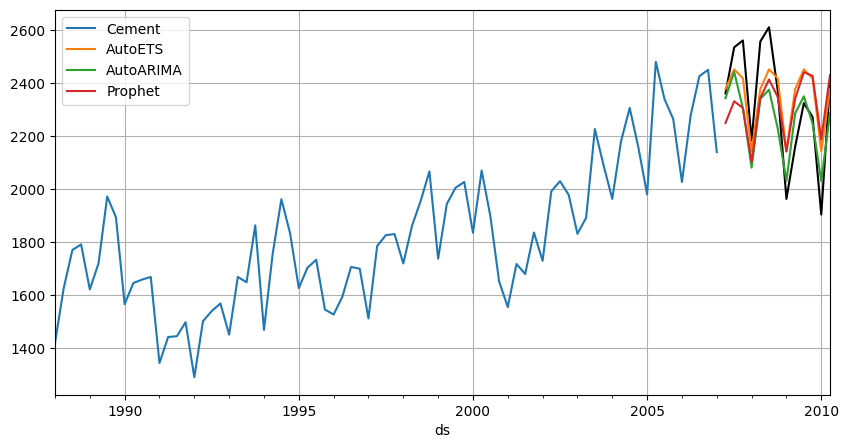

In [16]:
ax = train.plot(x="Quarter", y="Cement", figsize=(10, 5))
test.plot(x="Quarter", y="Cement", ax=ax, legend=None, color="k")
sf_forecast.plot(x="ds", ax=ax)
pp_forecast.plot(x="ds", ax=ax, label="A", grid=2);

In [11]:
forecast = pd.merge(pp_forecast, sf_forecast, how="inner", on="ds")

In [12]:
get_metrics(test.rename(columns={"Cement": "y"}), forecast).T

Total
metric model              
rmse   ets      142.709641
       arima    141.195050
       prophet  174.482674
mae    ets      123.192796
       arima    119.381986
       prophet  156.540650